# Lab03 - Validación de Modelos

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import model_selection, preprocessing
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## Cargar el set de datos
En este laboratorio vamos a validar qué tan bien se están comportando los modelos que realizamos la [clase pasada](./Lab02py_PrediccionClasificacion.ipynb).  Por eso fue tan importante guardar los modelos ya entrenados, para no tener que entrenarlos nuevamente.  
Vamos a continuar usando el set de datos que limpiamos y transformamos en el [primer laboratorio](./Lab01py_Preprocesamiento.ipynb) en donde se registran los atributos de varias botellas de vino junto con su calidad, ya que de este generamos los subsets de entrenamiento y prueba y es precisamente con el de **prueba** que vamos a probar y validar el modelo:

In [ ]:
wine_df = pd.read_csv('winequality-white_clean.csv')
len(wine_df)

4461

In [ ]:
wine_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,score
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.15
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.67
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.48
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.74
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.45


In [ ]:
y = wine_df['score']
x = wine_df.drop(['score'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## 3a. Regresión  
Si todo ha ido bien, en nuestro [laboratorio anterior](./Lab02py_RegresionClasificacion.ipynb), hemos guardado el modelo de regresión polinomial, que podemos validar en esta clase.  
Este modelo ya se encuentra entrenado y ahora, solo debemos cargarlo:

In [ ]:
with open("models/model_poly.pkl","rb") as f:
    model = pickle.load(f)

### Curvas de Validación
Como ya vimos, una de las formas de ver gráficamente en qué momento un modelo entra en sobreajuste debido a su complejidad es la *curva de Entrenamiento*.
> Vamos a crear una función para poderla usar con varios modelos, sin necesidad de repetir código:

In [ ]:
def curva_entrenamiento(modelo, x, y) :
    train_size, train_score, test_score = learning_curve(modelo, x, y, train_sizes = np.array([0.1, 0.33, 0.55, 0.78, 1.])) 
                                                         #train_sizes=np.linspace(.1, 1.0, 10))
    plt.plot(train_size,np.mean(train_score,axis=1), label="Score Entrenamiento")
    plt.plot(train_size,np.mean(test_score,axis=1),label="Score Pruebas")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()

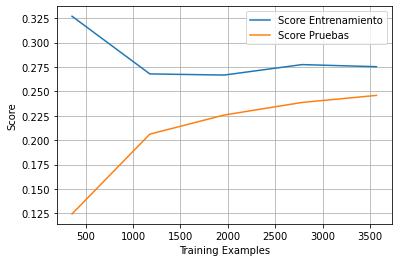

In [ ]:
curva_entrenamiento(model, x, y)

### Regularización
Aunque el modelo se ve bien, a medida que el dataset crece, podríamos validar hasta qué punto el modelo se empieza a sobreajustar.  Esto es, reducir la complejidad del modelo (Cantidad o peso de las variables) obteniendo el mismo o mejor resultado.  Para esto existen dos metodos conocidos.
> Tenga encuenta el factor de penalización del modelo recibe un nombre diferente en **Python** (*alpha*) y en **R** (*lambda*, que es como se conoce matemáticamente), pero el concepto, es el mismo.  
  
**Lasso:**

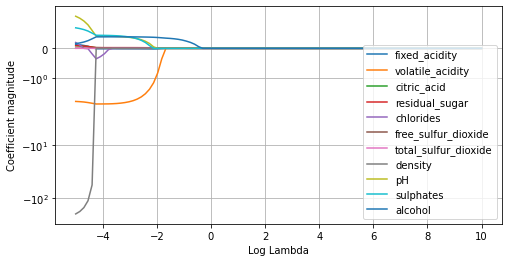

In [ ]:
a_exp = np.linspace(-5, 10, num=100)
alpha_range = [10**a for a in a_exp]
coefs = []

for i, alpha in enumerate(alpha_range):
    modelo = linear_model.Lasso(alpha=alpha)
    modelo.fit(x_train, y_train) # Solo aquí se está entrenando el modelo
    coefs.append(modelo.coef_)

plt.subplots(figsize=(8, 4))
plt.plot(a_exp, coefs)
plt.yscale("symlog")
plt.ylabel("Coefficient magnitude")
plt.xlabel("Log Lambda")
plt.legend(x_train.columns, loc='lower right')
plt.grid()

En la gráfica anterior se puede visualizar que si penalizamos mucho el peso de las variables (*alpha*), el modelo elimina todas las variables predictivas y esto no nos da ningún resultado.  Validemos ahora cuál es el mejor valor de alpha:

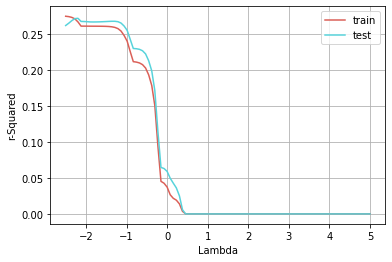

In [ ]:
colors = sns.hls_palette(2)

train_error = np.empty(len(alpha_range))
test_error = np.empty(len(alpha_range))
coefs = []

for i, alpha in enumerate(alpha_range):
    modelo = linear_model.Lasso(alpha=alpha)
    modelo.fit(x_train, y_train)

    train_error[i] = r2_score(y_train, modelo.predict(x_train))
    test_error[i] = r2_score(y_test, modelo.predict(x_test))
    coefs.append(modelo.coef_)

plt.plot(a_exp/2, train_error, label='train', color=colors[0])
plt.plot(a_exp/2, test_error, label='test', color=colors[1])
plt.ylabel('r-Squared')
plt.xlabel('Lambda')
plt.grid()
plt.legend(loc='upper right')

Revisemos, finalmente, el score de nuestro modelo bajo el mejor *alpha*.  Mejoro?

In [ ]:
modelo_reg = linear_model.Lasso(alpha=0.01)
modelo_reg.fit(x_train, y_train)
mean_squared_error(y_test, modelo_reg.predict(x_test))

0.5996084336868555

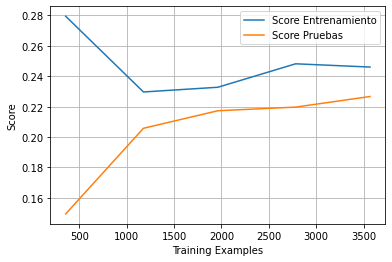

In [ ]:
curva_entrenamiento(modelo_reg, x, y)

**Taller**
- Pruebe con varios valores de *alpha* para mejorar el error mínimo cuadrado del modelo y la curva de entrenamiento
- Pruebe ahora cambiando la función *linear_model.Lasso()* por *linear_model.Ridge()* y haga el mismo ejercicio.
- Si queda algo de tiempo, intente eliminar columnas que, según nuestro analisis de los últimos días generan ruido en el modelo
- Finalmente, cuál es el mejor modelo que encontró?

## 2b. Clasificación  

In [ ]:
wine_df = pd.read_csv('winequality-red_clean.csv')
len(wine_df)

1571

In [ ]:
y = wine_df['high_quality']
x = wine_df.drop(['high_quality'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

En nuestro [laboratorio anterior](./Lab02py_RegresionClasificacion.ipynb), también hemos entrenado y guardado varios modelos de clasificación, que podemos validar en esta clase para encontrar el mejor:
- Regresión Logística (model_log.pkl)
- Vecinos más Cercanos (model_knn.pkl)
- Máquina de Soporte Vectorial (model_svm.pkl)
- Arbol de Desición (model_tree.pkl)
- Bosque Aleatorio (model_forest.pkl)

Elijamos inicialmente uno para hacer este laboratorio:

In [ ]:
with open("models/model_svm.pkl","rb") as f:
    modelo = pickle.load(f)

### Matriz de Confusión
Ya vimos en la sesion toda la información útil que nos entrega una matriz de confusión y todas las métricas que podemos sacar de ella.  
Afortunadamente, Python ofrece una serie de librerías que nos permiten calcular los valores de la matriz y sus métricas automaticamente y sin necesidad de contarlas a mano, sin importar el tamaño del dataset.
> Vamos a agrupar éstas métricas y gráficas en una sola función y así poder llamarla recurrentemente para cualquier modelo

In [ ]:
def plot_confussion_matrix(model, xtrain, ytrain, xtest, ytest, umbral=0.5):
    y_probs = model.predict_proba(xtest)
    y_pred = [int(p1 > umbral) for [p0, p1] in y_probs]
    conf = confusion_matrix(ytest, y_pred, normalize='all')
    conf = np.rot90(conf,2).T

    print ("     Accuracy:       %0.2f" %((conf[1,1]+conf[0,0])/(conf[1,1] + conf[0,1] + conf[0,0] + conf[1,0])))
    print ("     Precisión:      %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("     Recall:         %0.2f" % (conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("     Especificidad:  %0.2f" % (conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    
    plt.figure()
    sns.heatmap(conf, annot=True, cmap='Reds')
    plt.tight_layout()
    plt.ylabel('Predicción Modelo')
    plt.xlabel('Realidad')


     Accuracy:       0.63
     Precisión:      0.61
     Recall:         0.84
     Especificidad:  0.40


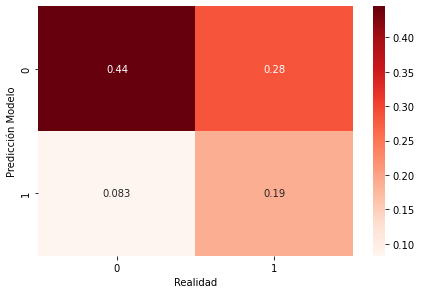

In [ ]:
plot_confussion_matrix(modelo ,x_train, y_train, x_test, y_test)

### Curva ROC y AUC

La curva ROC (*Receiving Operating Characteristic*) y el área bajo ella, nos permiten validar gráficamente qué tan bien está prediciendo el modelo.  Se trata de una relacion entre la Tasa de Verdaderos Positivos (TPR o Sensitividad) que queremos aumentar y la de Falsos Positivos (FPR o 100 - Especificidad) que queremos disminuir.

Tenga en cuenta que el "Mejor modelo" es el que tiene **Área Bajo la Curva (AUC) = 1** es decir, pasa por la esquina superior izquierda (0,1) y el "Modelo Base" (Aleatorio) es el que tiene **Área Bajo la Curva (AUC) = 0.5** es decir pasa por la diagonal (1,1)

In [ ]:
def plot_roc_curve(model, x_test, y_test):
    y_score=model.predict_proba(x_test)[:,1]

    fpr, tpr, ths = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot([0,1],[0,1]) # Modelo Aleatorio
    plt.plot(fpr,tpr,color='green')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC (AUC = ' + str(roc_auc)+ ')')

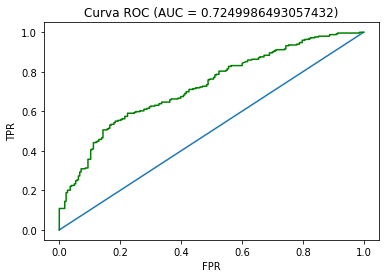

In [ ]:
plot_roc_curve(modelo, x_test, y_test)

### Ajuste del Umbral

La curva ROC nos muestra los valores de TPR y FPR para diferentes umbrales del mismo modelo.  Debemos buscar un modelo que tenga el área bajo la curva máxima y entonces, elegir el umbral que aporte el valor máximo de esta curva.  pero cuál es ese umbral óptimo?

Si elegimos un umbral muy alto (Mayor a 0.5 y cercano a 1), el modelo clasificará una menor cantidad de casos positivos (TPR).  Si elegimos un umbral muy bajo (Menor a 0.5 y cercano a 0), el modelo clasificará una mayor cantidad de casos positivos y podría equivocarse (FPR).

In [ ]:
def plot_precision_recall(model, x_test, y_test) :
    y_score = model.predict_proba(x_test)[:,1]
    p,r,t = precision_recall_curve(y_test,y_score)
    t=np.vstack([t.reshape([-1,1]),1])

    plt.plot(t,p, label='Precisión')
    plt.plot(t,r, label='Recall')
    plt.legend()
    plt.grid()

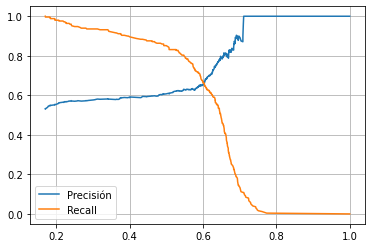

In [ ]:
plot_precision_recall(modelo, x_test, y_test)

Es buena práctica, tomar como umbral para nuestro modelo, no siempre 0.5, sino el punto en el que las dos líneas se crucen tal que: La **precisión** del modelo aumente, pero no tanto para que el **recall** caiga demasiado.  

Recuerde que, al cambiar el umbral con el que se mide un modelo, se genera un modelo completamente diferente al que se le deben volver a medir las métricas de validación, por suerte, creamos una función para ello:

     Accuracy:       0.64
     Precisión:      0.65
     Recall:         0.67
     Especificidad:  0.61


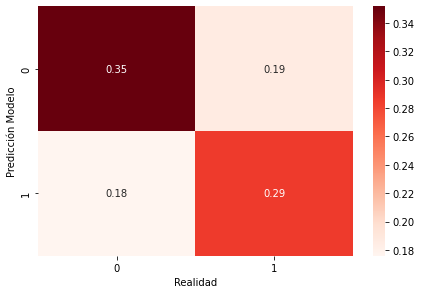

In [ ]:
plot_confussion_matrix(modelo ,x_train, y_train, x_test, y_test, umbral=0.6)

**Taller:**
- Valide las diferentes métricas y gráficas para los modelos que creamos la clase pasada (Se recomienda hacerlo en nuevas celdas, reutilizando las funciones ya creadas, para poder comparar los diferentes modelos)
- Juegue un poco con el umbral del modelo, recuerde que las graficas de las curvas de validación son una recomendación, pero un científico de datos puede moverse con flexibilidad en un rango cercano a ese valor.
- Si queda algo de tiempo, intente eliminar columnas que, según nuestro analisis de los últimos días generan ruido en el modelo o cambiar algunos hiperparámetros
- Finalmente, cuál es el mejor modelo que encontró?